In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas
import math
from matplotlib import animation
from matplotlib.animation import PillowWriter

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [10 , 10]

# Units

In [2]:
G_pu = 6.67430e-8       #cm^3 g^-1 s^-2
r_pu = 1.49597870707e13 #cm
m_pu = 1.989e33         #g

v_pu = np.sqrt(G_pu * m_pu / r_pu) #cm/s

time_pu = r_pu/v_pu #seconds

E_pu = G_pu*(m_pu**2)/r_pu #cm^2 g s^-2 = erg

Rescaling

In [3]:
v_pu = v_pu/1e5 #km/s
print(f"v_pu/v_iu = {v_pu:.2f} (km/s)/iu")

time_pu = time_pu/(3.156e7) #years
print(f"time_pu/time_iu = {time_pu:.3f} years/iu")

E_pu 
print(f"E_pu/E_iu = {E_pu:.2e} erg/iu")

v_pu/v_iu = 29.79 (km/s)/iu
time_pu/time_iu = 0.159 years/iu
E_pu/E_iu = 1.77e+46 erg/iu


# Computing the angular momentum and the total energy in the CM-frame at $t=0$ 

In [4]:
data = pandas.read_csv('./twobody.in',
                        sep='\s+',
                        names=['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz'],
                        engine='python')

data

,mass,x,y,z,vx,vy,vz
0,2,NaN,NaN,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,-1.0,0.0,0.0,0.0,-0.316,0.0
3,1,1.0,0.0,0.0,0.0,0.316,0.0


In [5]:
m1 = data.iloc[2].to_numpy()[0]
m2 = data.iloc[3].to_numpy()[0]

pos1 = data.iloc[2].to_numpy()[1:4]
pos2 = data.iloc[3].to_numpy()[1:4]
r0 = pos2-pos1

v1 = data.iloc[2].to_numpy()[4:]
v2 = data.iloc[3].to_numpy()[4:]

We move from the initial-conditions-frame to the **center-of-mass-frame**.\
The primed quantities are defined in the CM-frame.

$$\vec{R}_{cm} = \dfrac{m_1\vec{r}_1 + m_2\vec{r}_2}{m_1 + m_2} \:\: \Rightarrow \:\: 0 = \dfrac{m_1(\vec{r}_1-\vec{R}_{cm}) + m_2(\vec{r}_2-\vec{R}_{cm})}{m_1 + m_2} \doteq \dfrac{m_1\vec{r'}_1 + m_2\vec{r'}_2}{m_1 + m_2} $$

$$
\begin{cases}
      m_1\vec{r'}_1 + m_2\vec{r'}_2 = 0\\
      r \doteq \vec{r}_2 - \vec{r}_1 = \vec{r'}_2 - \vec{r'}_1
\end{cases}
\Longrightarrow
\begin{cases}
      \vec{r'}_1 = -\frac{m_2}{m_1}\vec{r'}_2\\
      r = \vec{r'}_2 + \frac{m_2}{m_1}\vec{r'}_2
\end{cases}
\Longrightarrow
\begin{cases}
      \vec{r'}_1 = -\frac{m_2}{m_1+m_2}r\\
      \vec{r'}_2 = \frac{m_1}{m_1+m_2}r
\end{cases}
$$

We also transform the velocities:

$$\vec{v}_{cm} = \dfrac{m_1\vec{v}_1 + m_2\vec{v}_2}{m_1 + m_2}$$

$$
\begin{cases}
      \vec{v'}_1 = \vec{v}_1 - \vec{v}_{cm}\\
      \vec{v'}_2 = \vec{v}_2 - \vec{v}_{cm}
\end{cases}
\Longrightarrow
\begin{cases}
      \vec{v'}_1 = \frac{m_2}{m_1 + m_2}(\vec{v}_1 - \vec{v}_2)\\
      \vec{v'}_2 = \frac{m_1}{m_1 + m_2}(\vec{v}_2 - \vec{v}_1)
\end{cases}

In [6]:
def PosToCM(r):
    return -r*m2/(m1+m2), r*m1/(m1+m2)

def VelToCM(v1, v2):
    return (v1-v2)*m2/(m1+m2), (v2-v1)*m1/(m1+m2)

pos1_cm, pos2_cm = PosToCM(r0)
v1_cm, v2_cm = VelToCM(v1, v2)

In this way, we are able to compute the total energy in the CM-frame:

$$E\vert_{CM} = \dfrac{1}{2}m_1|\vec{v'}_1|^2 + \dfrac{1}{2}m_2|\vec{v'}_2|^2 - \dfrac{m_1m_2}{r}$$

In [7]:
E_grav = -m1*m2/(np.linalg.norm(r0))
E_kin1 = 0.5*m1*(np.linalg.norm(v1_cm))**2
E_kin2 = 0.5*m2*(np.linalg.norm(v2_cm))**2
E_tot = E_grav + E_kin1 + E_kin2
print("E_tot = ", E_tot, "internal units")
#print("E_tot would be zero if v =", np.sqrt(2/np.linalg.norm(r)))

E_tot =  -0.40014400000000006 internal units


We can also compute the angular momentum in the CM-frame and, as a consequence, the **effective potential** of the system:

$$\vec{L}\vert_{CM} = m_1(\vec{r'}_1\times\vec{v'}_1) + m_2(\vec{r'}_2\times\vec{v'}_2)$$

In [8]:
L = m1*np.linalg.norm(np.cross(pos1_cm, v1_cm)) + m2*np.linalg.norm(np.cross(pos2_cm, v2_cm))

$$V_{eff} = \dfrac{L\vert_{CM}^2}{2 \mu r^2} - \dfrac{m_1 m_2}{r}$$

In [9]:
mu = m1*m2/(m1+m2)

def V_eff(x):
    return (L**2)/(2*mu*x**2) - m1*m2/x

# Plot & Animation

In [10]:
data = pandas.read_csv('./twobody.out',
                        sep='\s+',
                        names=['time', 'x1', 'y1', 'z1', 'vx1', 'vy1', 'vz1', 'x2', 'y2', 'z2', 'vx2', 'vy2', 'vz2'],
                        engine='python')

time = data["time"].to_numpy()*time_pu #years
x1 = data["x1"].to_numpy()
y1 = data["y1"].to_numpy()
z1 = data["z1"].to_numpy()
vx1 = data["vx1"].to_numpy()
vy1 = data["vy1"].to_numpy()
vz1 = data["vz1"].to_numpy()
x2 = data["x2"].to_numpy()
y2 = data["y2"].to_numpy()
z2 = data["z2"].to_numpy()
vx2 = data["vx2"].to_numpy()
vy2 = data["vy2"].to_numpy()
vz2 = data["vz2"].to_numpy()

In [11]:
r = np.array([x2-x1, y2-y1, z2-z1])

dist = np.linalg.norm(r, axis=0)

In [12]:
#v2_initial = np.array([vx2[0], vy2[0], vz2[0]]) 
#v2_final = np.array([vx2[-1], vy2[-1], vz2[-1]]) 
#theta_dev = np.arccos(np.dot(v2_initial, v2_final)/(np.linalg.norm(v2_initial)*np.linalg.norm(v2_final)))
#np.rad2deg(theta_dev)

In [13]:
#theta_dev_formula = -np.pi + 2*np.arctan(-np.abs(y2[0])*np.linalg.norm(v2_initial)**2/m1) + 2*np.pi
#np.rad2deg(theta_dev_formula)

In [14]:
aphelion = np.max(dist)
print(f'Aphelion = {aphelion:.5f} au = {aphelion*r_pu*1e-5:.0f} km')

Aphelion = 2.00000 au = 299195402 km


In [15]:
[x1, y1, z1], [x2, y2, z2] = PosToCM(r)
[vx1, vy1, vz1], [vx2, vy2, vz2] = VelToCM(np.array([vx1, vy1, vz1]), np.array([vx2, vy2, vz2]))

### Plot

In [16]:
x_min = np.min([x1,x2])
x_max = np.max([x1,x2])
y_min = np.min([y1,y2])
y_max = np.max([y1,y2])
coord_min = np.min([x_min, y_min])
coord_max = np.max([x_max, y_max])

Text(0, 0.5, 'y[au]')

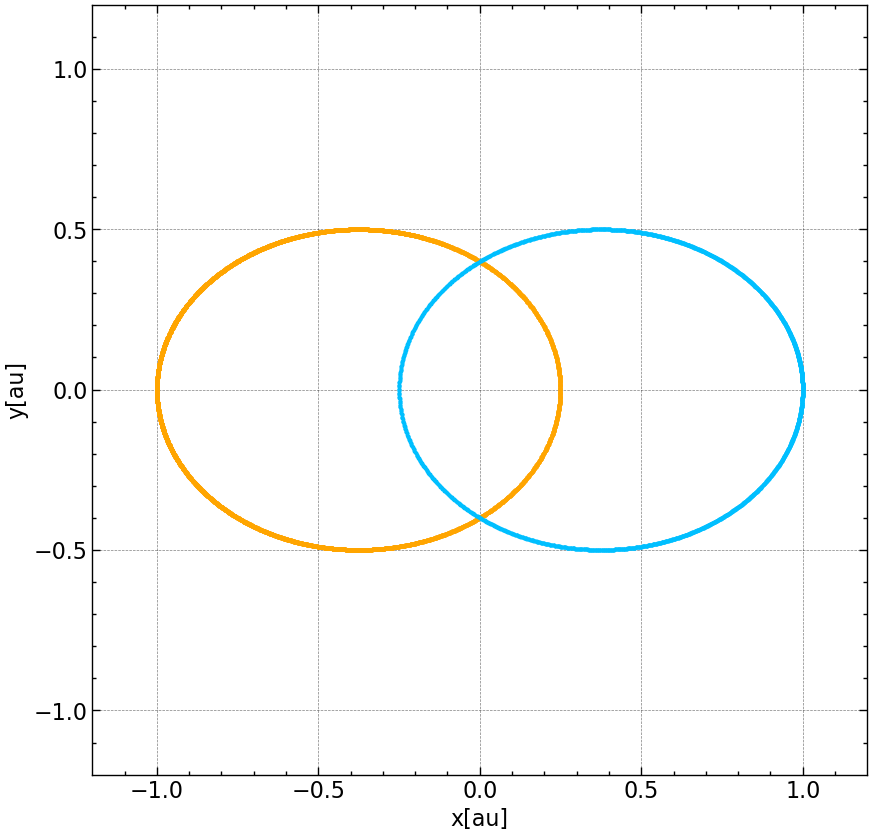

In [17]:
plt.scatter(x1, y1, marker='o', s=5, color='orange')
plt.scatter(x2, y2, marker='o', s=3, color='deepskyblue')
plt.xlim(1.2*coord_min, 1.2*coord_max)
plt.ylim(1.2*coord_min, 1.2*coord_max)
#plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x[au]')
plt.ylabel('y[au]')

### Animation

In [23]:
# if len(x1)=N, then the animation will have N/k frames
k = 5

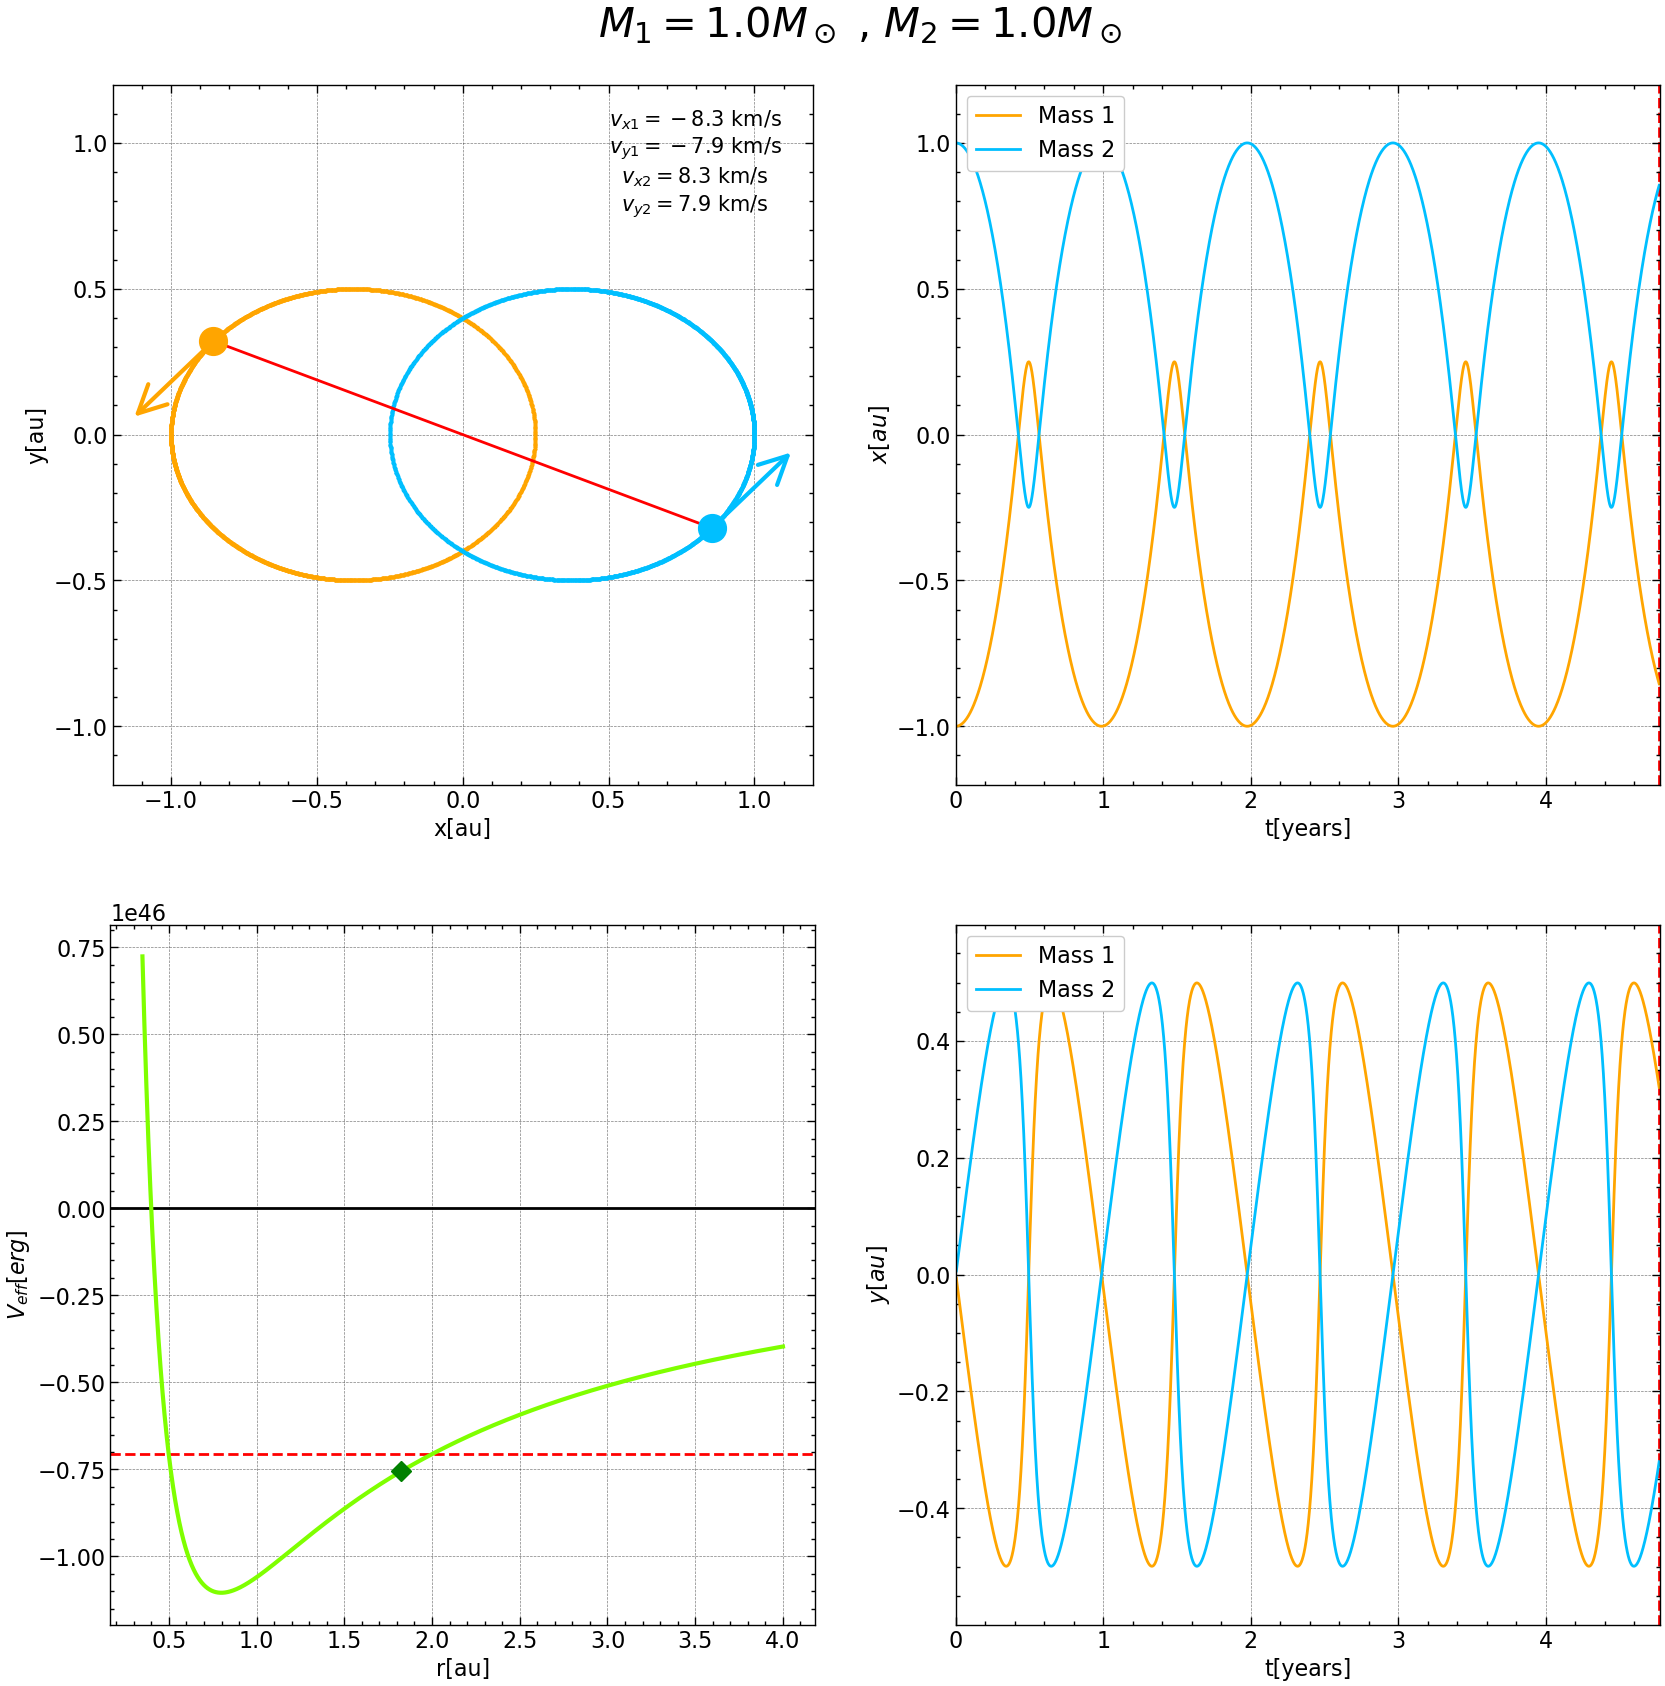

In [42]:
#fig = plt.Figure() #somehow faster than fig, ax = plt.subplots(1,1), but text doesn't work well
#ax = fig.add_subplot()
plt.rcParams['figure.figsize'] = [20 , 20]
fig, axes = plt.subplots(2,2)
fig.suptitle(f'$M_1={m1}M_\odot$ , $M_2={m2}M_\odot$', fontsize=30, y=0.92)

ax = axes[0][0]
ax.clear()
ax.set_xlim(1.2*coord_min, 1.2*coord_max)
ax.set_ylim(1.2*coord_min, 1.2*coord_max)
ax.set_aspect('equal')
ax.set_xlabel('x[au]')
ax.set_ylabel('y[au]')
ax.scatter(x1, y1, marker='o', s=3, color='orange', zorder=1)
ax.scatter(x2, y2, marker='o', s=3, color='deepskyblue', zorder=1)
one, = ax.plot([], [], 'o', color='orange', markersize=20, zorder=2)
two, = ax.plot([], [], 'o', color='deepskyblue', markersize=20, zorder=2)
v_one = patches.FancyArrowPatch((0, 0), (0, 0), color='orange', arrowstyle='->', linewidth=3, mutation_scale=50)
ax.add_patch(v_one)
v_two = patches.FancyArrowPatch((0, 0), (0, 0), color='deepskyblue', arrowstyle='->', linewidth=3, mutation_scale=50)
ax.add_patch(v_two)
distance, = ax.plot([], [], 'ro-', zorder=1)
text = ax.text(-0.37, 2.02, 'asdasd', transform = fig.gca().transAxes, fontsize=15, backgroundcolor='white', ha='center', zorder=0)

ax = axes[1][0]
x_dense = np.linspace(0.7*np.min(dist), 2*np.max(dist), 10000)
ax.plot(x_dense, V_eff(x_dense)*E_pu, color='chartreuse', linewidth=3)
ax.axhline(0, ls='-', color='black', zorder=0)
ax.axhline(E_tot*E_pu, ls='--', color='red', label='Total Energy', zorder=1)
ax.set_xlabel('r[au]')
ax.set_ylabel('$V_{eff}[erg]$')
potential, = ax.plot([], [], 'D', color='green', markersize=10, zorder=4)

#ax.set_xlim(0.95, 1.05)
#ax.set_ylim(-2.65e40, -2.64e40)
#ax.axvline(aphelion, ls='-', lw=4, color='gold', label=f'Simulation Aphelion = {aphelion:.4f} au', zorder=2)
#ax.axvline(1.0167, ls='--', color='black', label=f'Actual Aphelion = {1.0167} au', zorder=3)
#ax.legend()

ax = axes[0][1]
ax.set_xlim(0, np.max(time))
ax.set_ylim(1.2*x_min, 1.2*x_max)
ax.set_xlabel('t[years]')
ax.set_ylabel('$x[au]$')
plot_x1, = ax.plot([],[], color='orange', label='Mass 1')
plot_x2, = ax.plot([],[], color='deepskyblue', label='Mass 2')
plot_x2_vline = ax.axvline(0, linestyle='--', color='red', zorder=0)
ax.legend(loc='upper left')

ax = axes[1][1]
ax.set_xlim(0, np.max(time))
ax.set_ylim(1.2*y_min, 1.2*y_max)
ax.set_xlabel('t[years]')
ax.set_ylabel('$y[au]$')
plot_y1, = ax.plot([],[], color='orange', label='Mass 1')
plot_y2, = ax.plot([],[], color='deepskyblue', label='Mass 2')
plot_y2_vline = ax.axvline(0, ls='--', c='red', zorder=0)
ax.legend(loc='upper left')


def animate(i):
    print(math.ceil(100*i*k/len(x1)), "%", end='\r')
    x_one, y_one = x1[k*i], y1[k*i]
    x_two, y_two = x2[k*i], y2[k*i]
    one.set_data([x_one], [y_one])
    two.set_data([x_two], [y_two])
    v_one.set_positions((x_one, y_one), (x_one + vx1[k*i], y_one + vy1[k*i]))
    v_two.set_positions((x_two, y_two), (x_two + vx2[k*i], y_two + vy2[k*i]))
    distance.set_data([x_one, x_two], [y_one, y_two])
    textstr = '\n'.join((
        r'$v_{x1} = %.1f$ km/s' %(vx1[k*i]*v_pu),
        r'$v_{y1} = %.1f$ km/s' %(vy1[k*i]*v_pu),
        r'$v_{x2} = %.1f$ km/s' %(vx2[k*i]*v_pu),
        r'$v_{y2} = %.1f$ km/s' %(vy2[k*i]*v_pu)
        ))
    text.set_text(textstr)
    potential.set_data([dist[k*i]], [V_eff(dist[k*i])*E_pu])
    plot_x1.set_data(time[:k*i], x1[:k*i])
    plot_x2.set_data(time[:k*i], x2[:k*i])
    plot_y1.set_data(time[:k*i], y1[:k*i])
    plot_y2.set_data(time[:k*i], y2[:k*i])
    plot_x2_vline.set_xdata([time[k*i], time[k*i]])
    plot_y2_vline.set_xdata([time[k*i], time[k*i]])
    return one, two,

writer = animation.FFMpegWriter(fps=60)
ani = animation.FuncAnimation(fig, animate, frames=int(len(x1)/k), interval=1, blit=True)
ani.save('twobody.gif', writer=writer, dpi=100)